# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [368]:
#%pip install numpy
#%pip install matplotlib
#%pip install pandas
#%pip install seaborn
#%pip install scikit-learn
#%pip install missingno
#%pip install imblearn

In [369]:
import warnings

warnings.filterwarnings('ignore')

import self_functions as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 1. Loading data

In [370]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')
test_data_ids = test_data['id']

# 2. Inspecting data

## 2.1 Inspecting missing data

<Axes: >

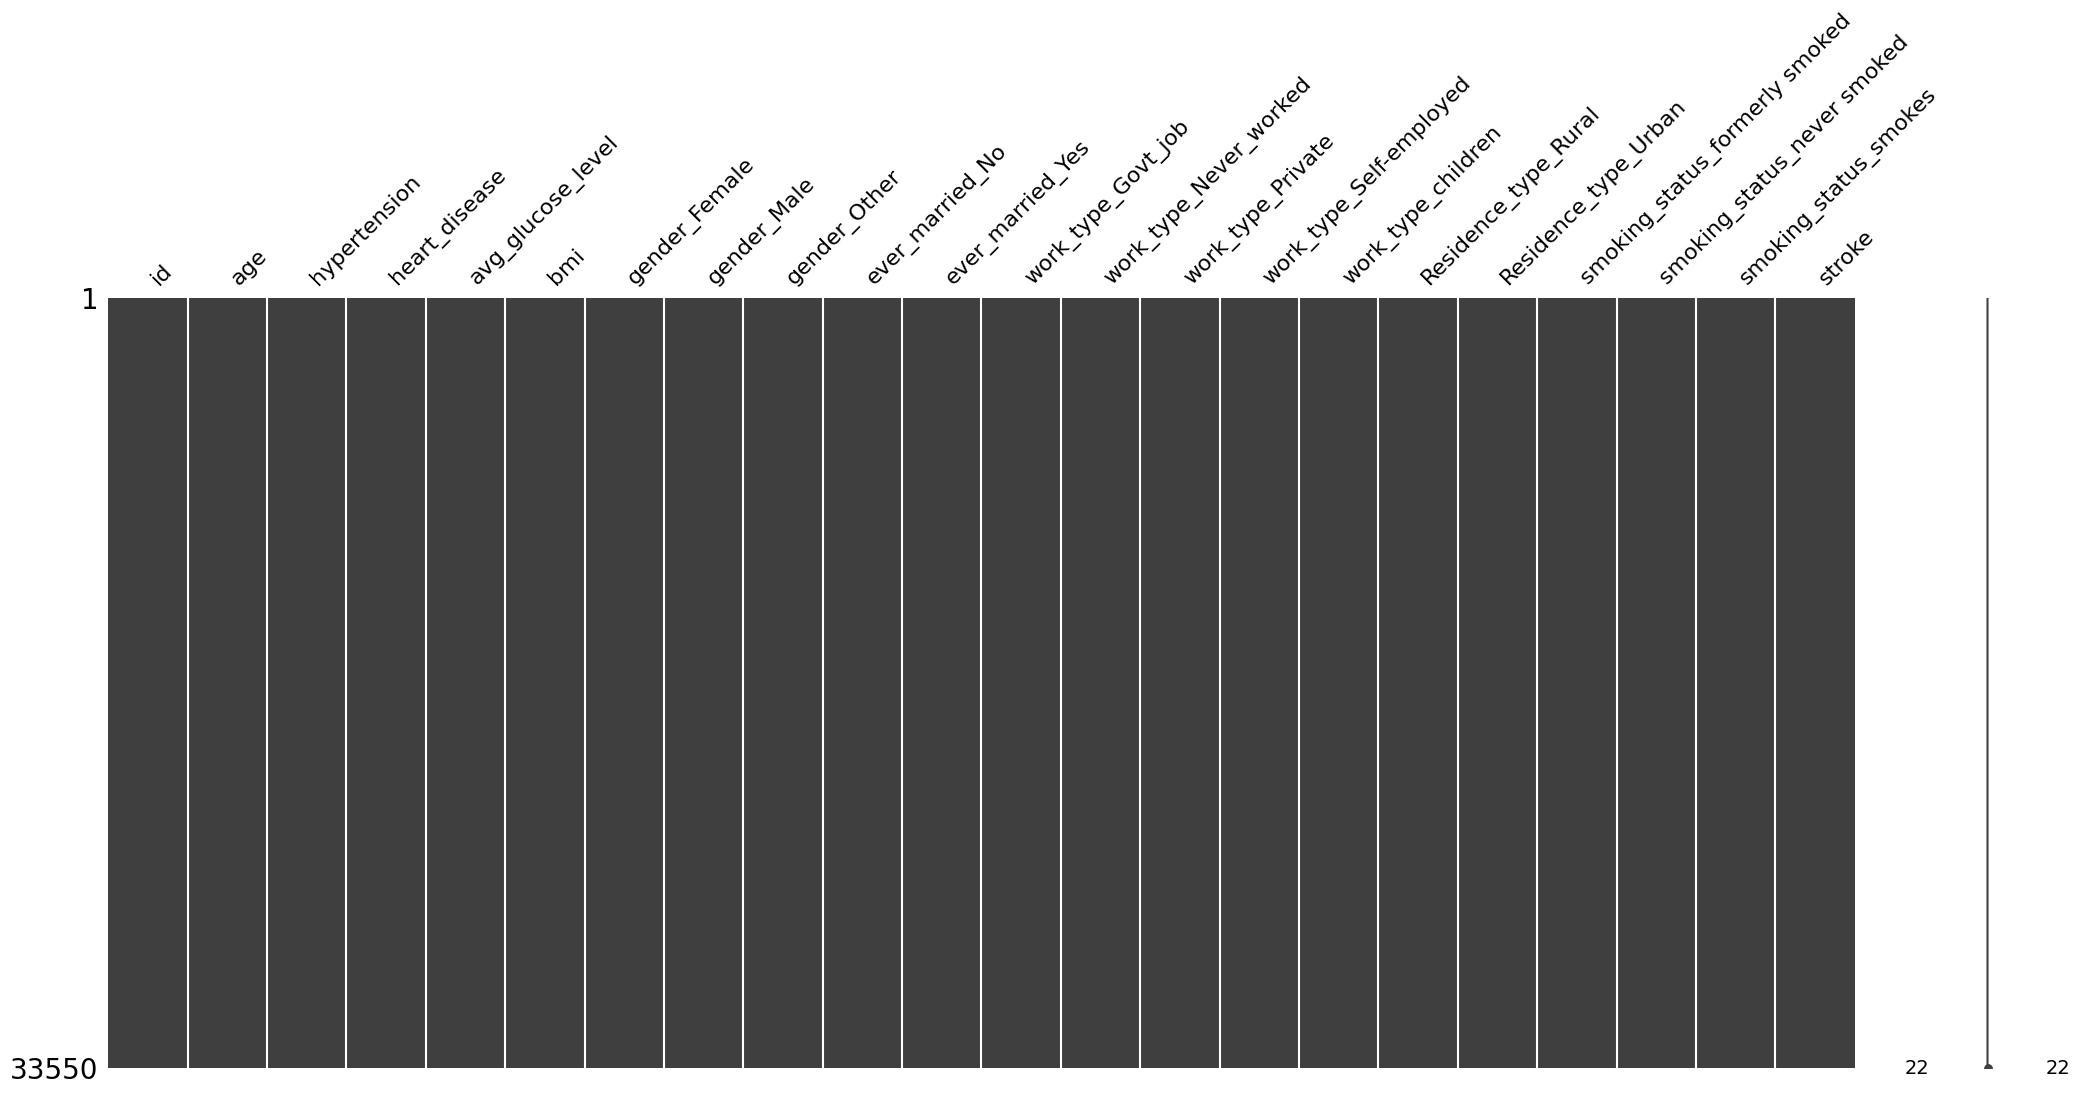

In [371]:
msno.matrix(train_data)

There is no missing data in the train dataset

<Axes: >

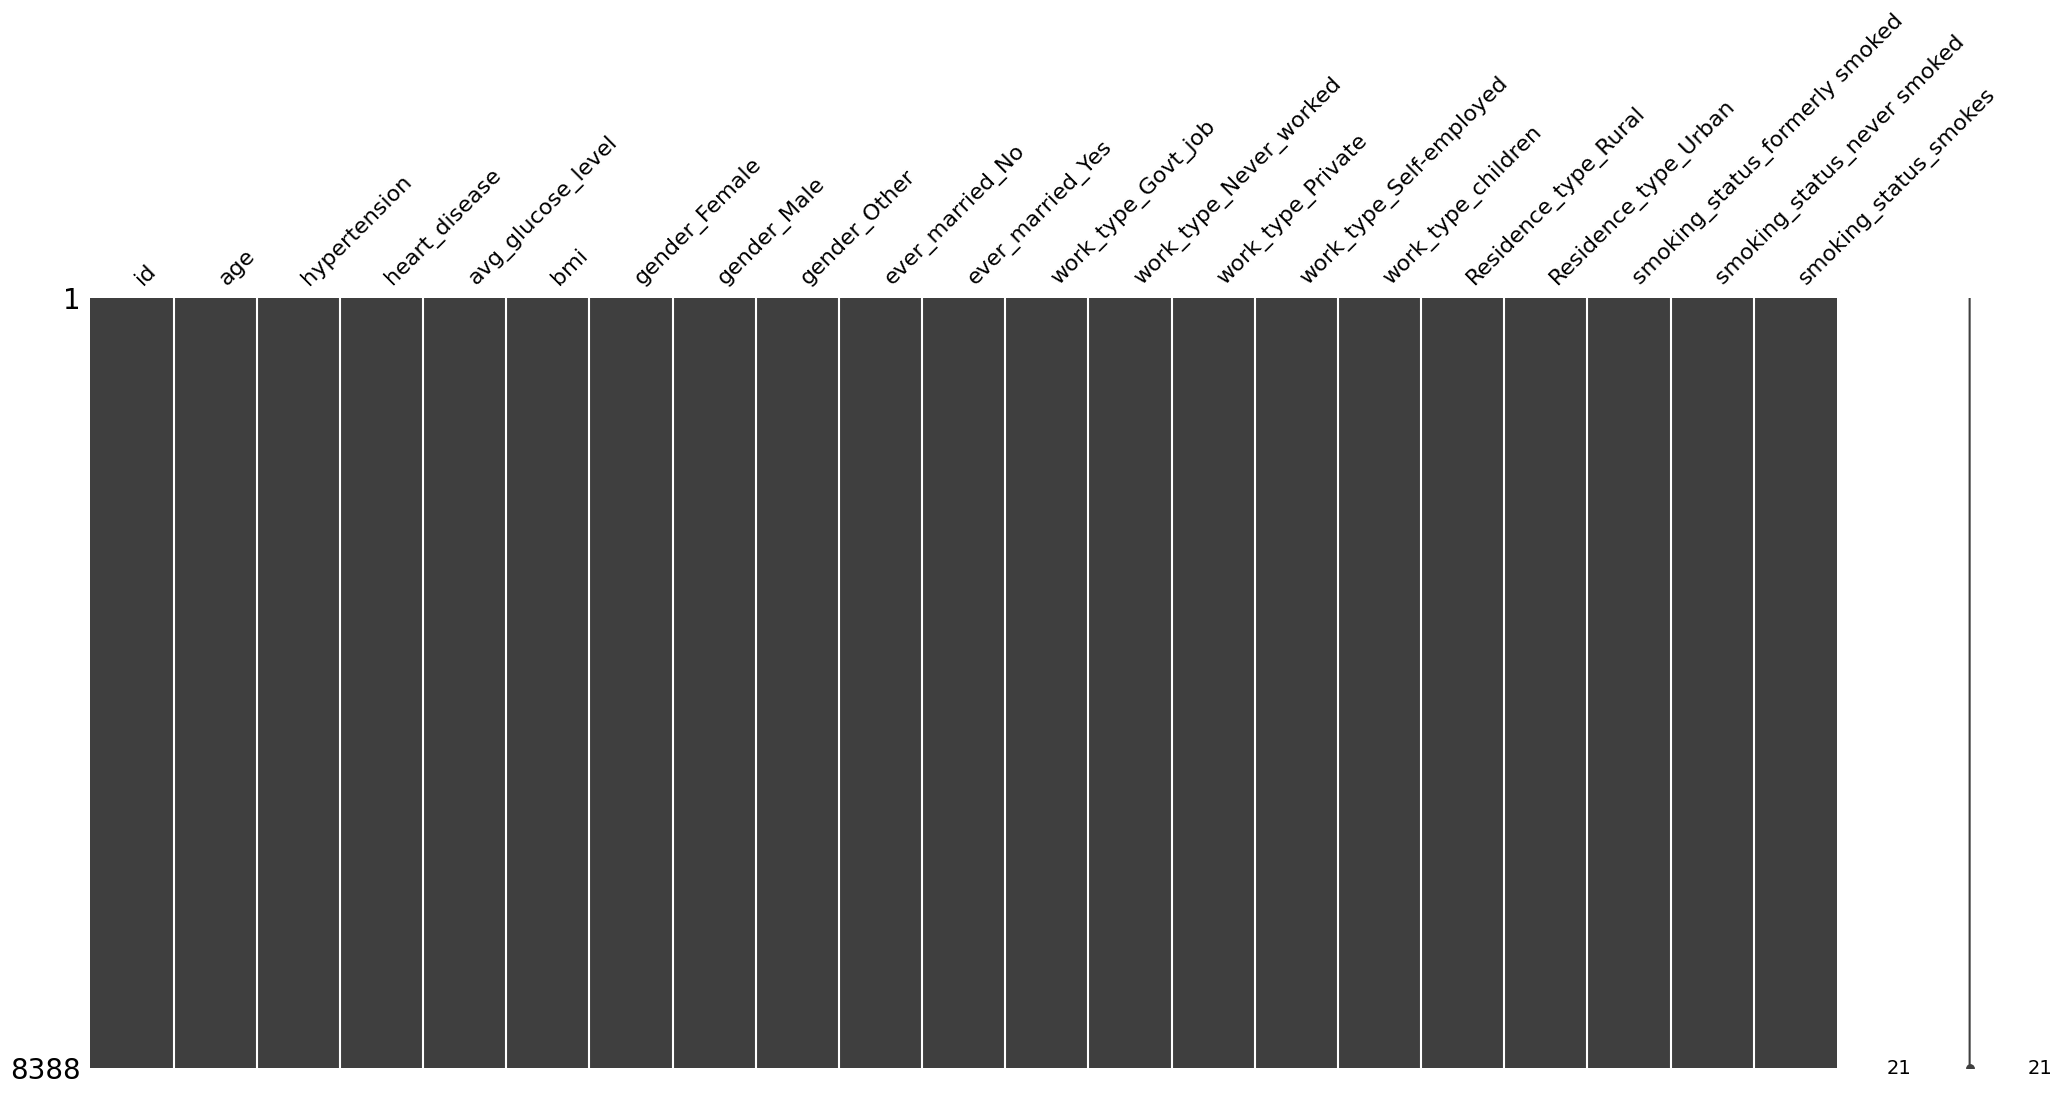

In [372]:
msno.matrix(test_data)

There is no missing data in the test dataset

## 2.2 Inspecting individual columns

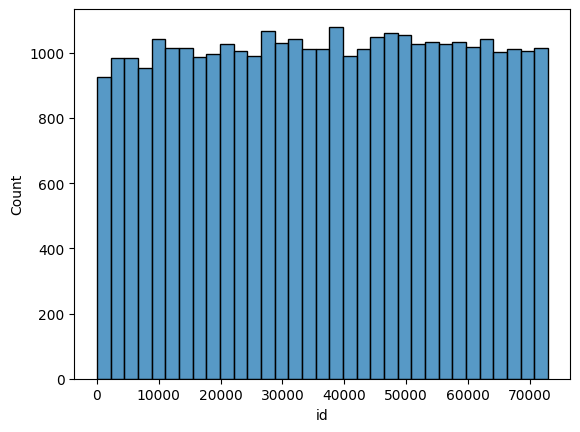

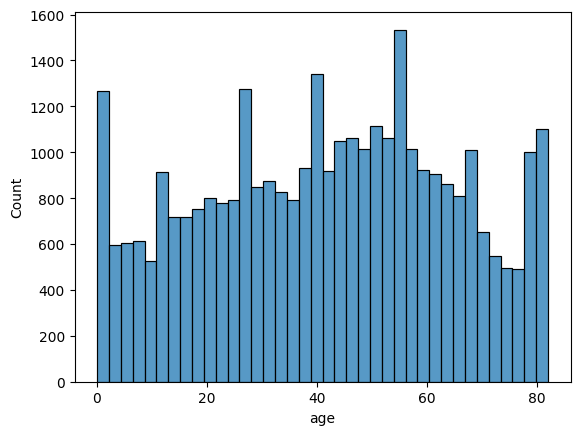

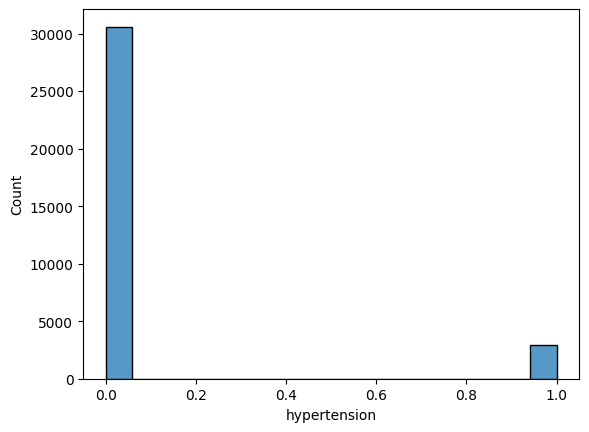

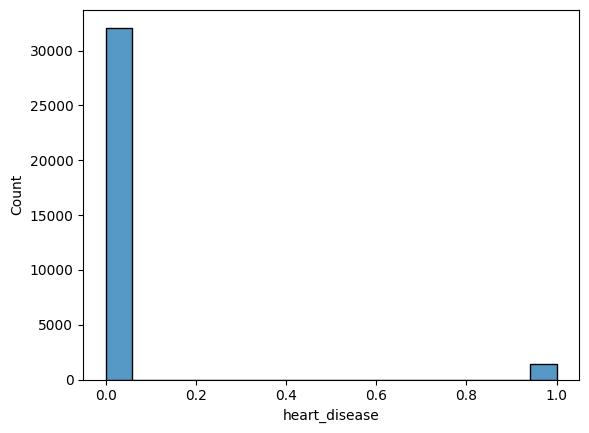

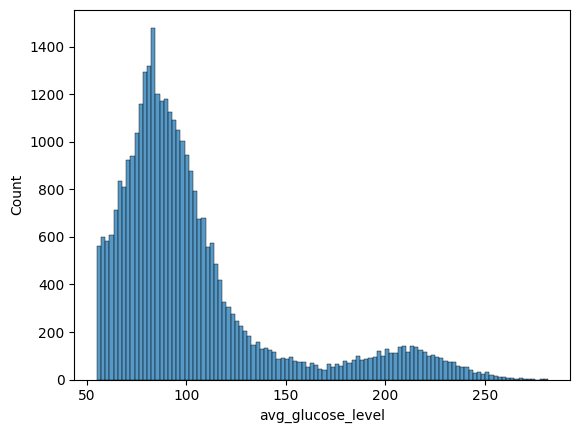

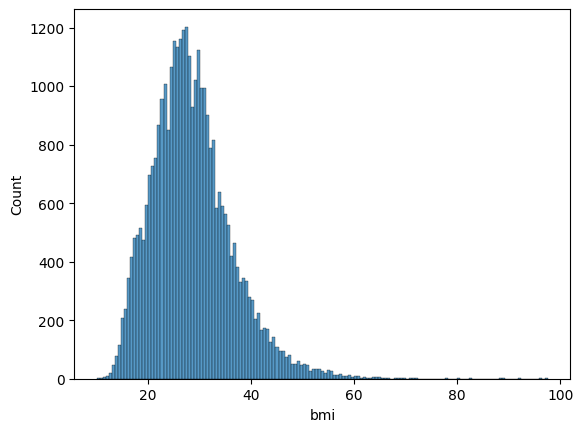

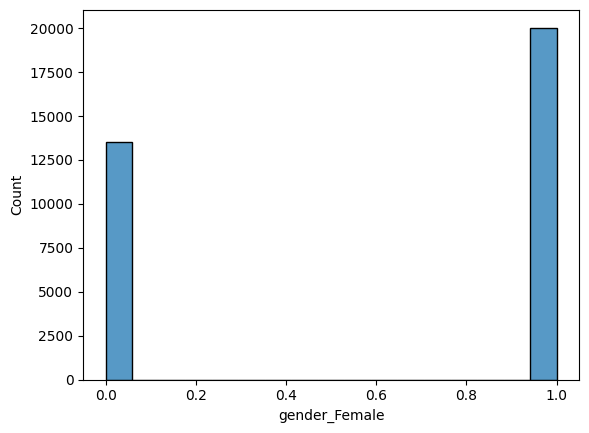

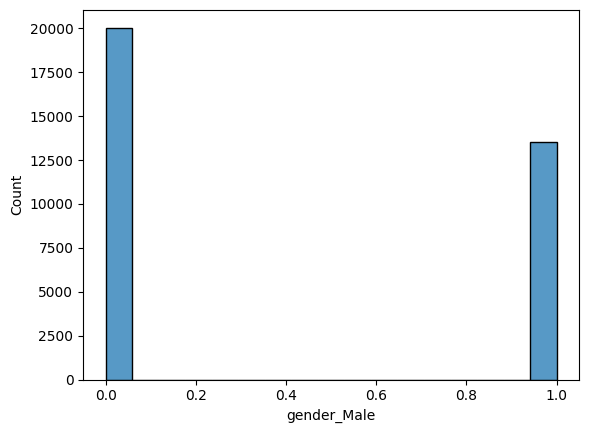

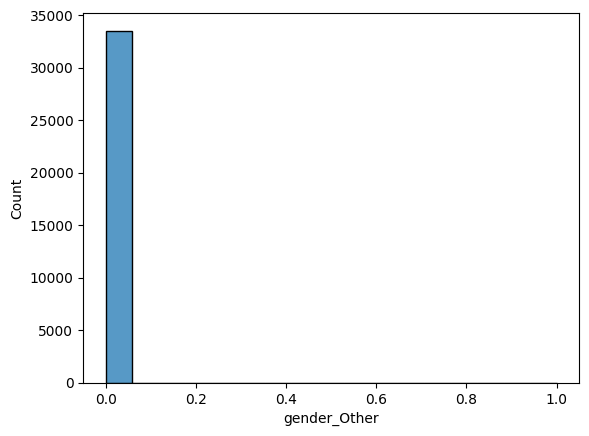

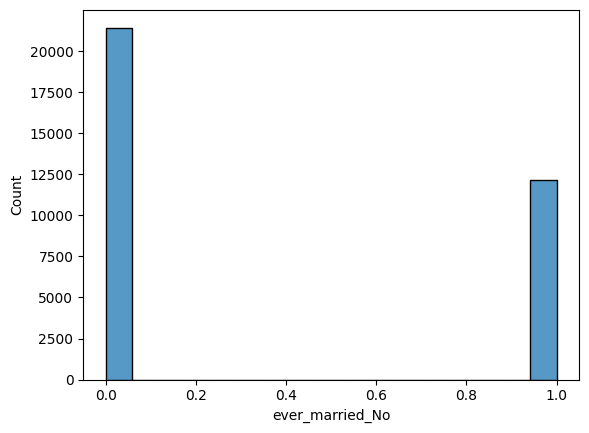

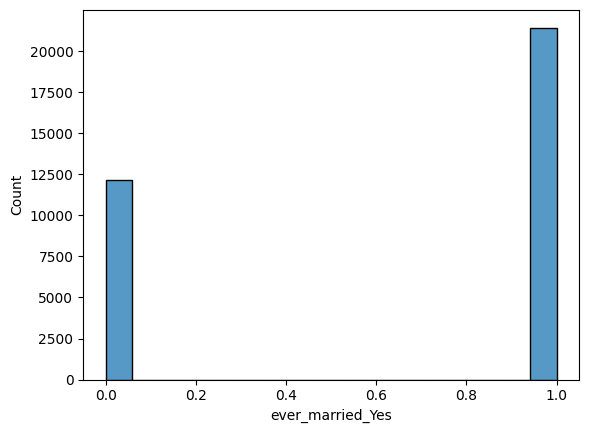

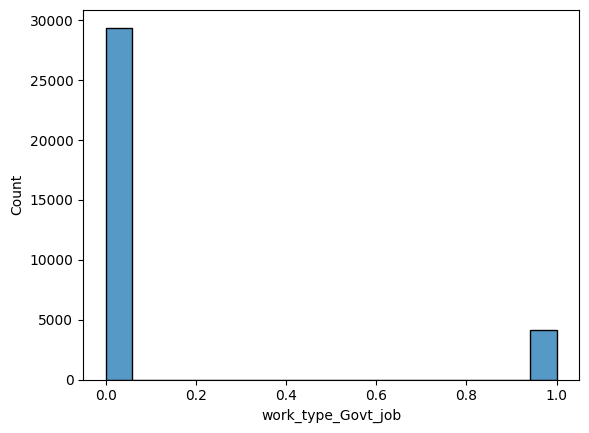

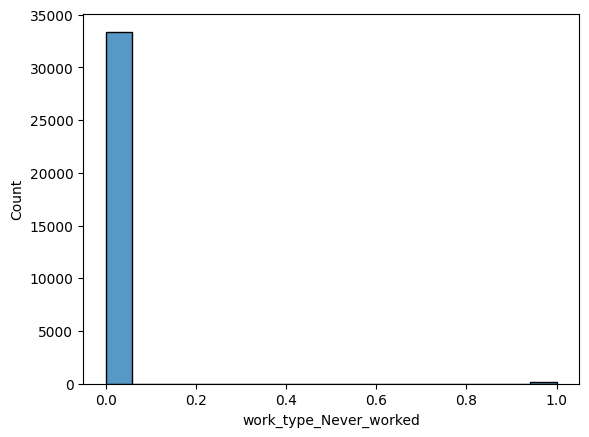

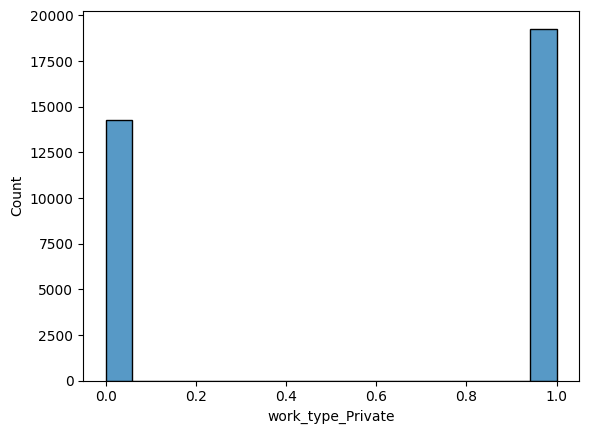

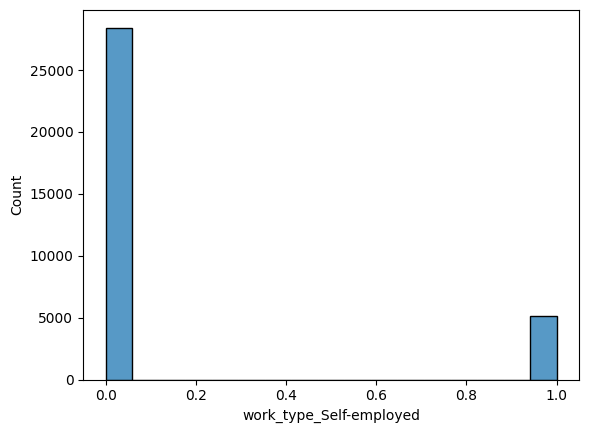

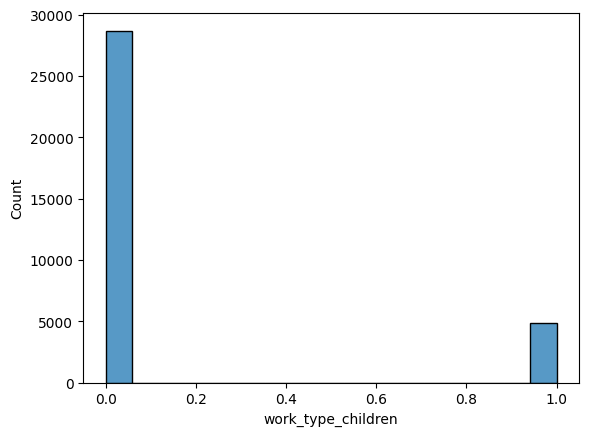

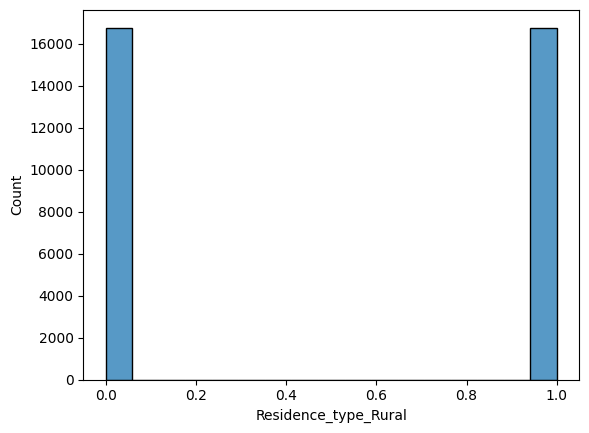

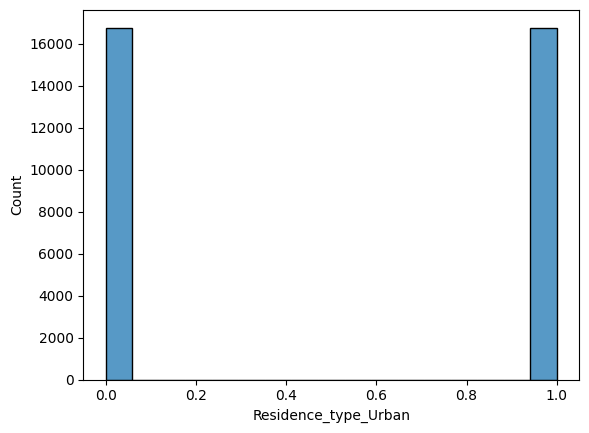

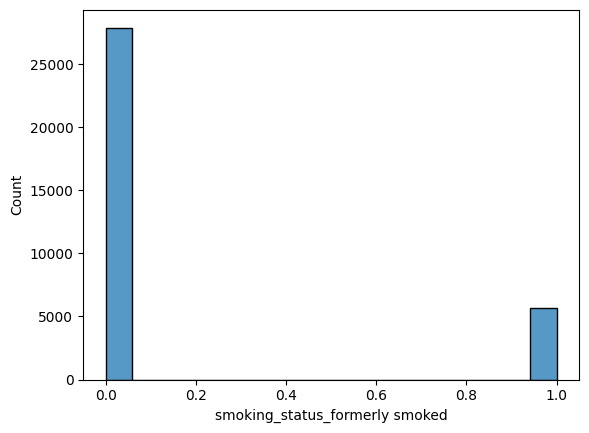

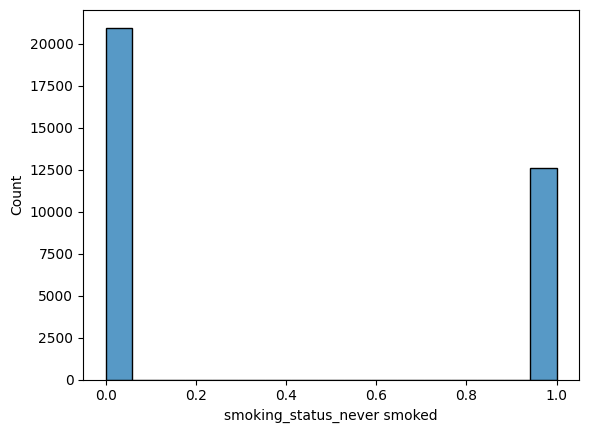

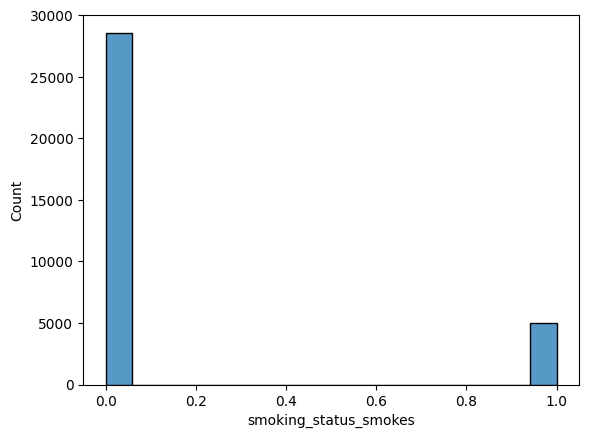

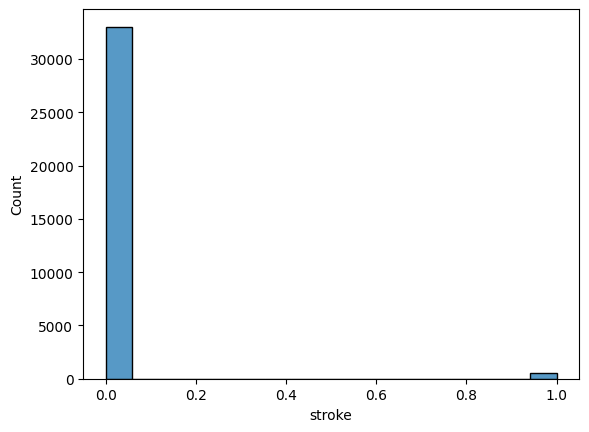

In [373]:
for i in train_data.columns:
    sf.histplot(train_data[i])

There is a low amount of people diagnosed with hypertension and/or heart disease.</br>
The distribution for both the average glucose level and BMI is a right-skewed normal distribution.</br>
There are more women than men in the dataset, there are no people who identify as other in the dataset.</br>
The biggest group of people work at private companies.</br>
There is a 50/50 spread of people living in a rural area vs an urban area.</br>
There is an approximate 50/50 split for people who have ever smoked and people who have never smoked, for the people who have ever smoked it is split 50/50 for active smokers and former smokers.</br>

There is only a low amount of people who have ever had a stroke (imbalanced dataset), which will make it difficult to correctly predict when someone will be having a stroke, therefore later on we will be oversampling the data to make it more useable for machine learning

## 2.3 Datatypes

In [374]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33550 entries, 0 to 33549
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33550 non-null  int64  
 1   age                             33550 non-null  float64
 2   hypertension                    33550 non-null  int64  
 3   heart_disease                   33550 non-null  int64  
 4   avg_glucose_level               33550 non-null  float64
 5   bmi                             33550 non-null  float64
 6   gender_Female                   33550 non-null  bool   
 7   gender_Male                     33550 non-null  bool   
 8   gender_Other                    33550 non-null  bool   
 9   ever_married_No                 33550 non-null  bool   
 10  ever_married_Yes                33550 non-null  bool   
 11  work_type_Govt_job              33550 non-null  bool   
 12  work_type_Never_worked          

## 2.4 Relationships between variables

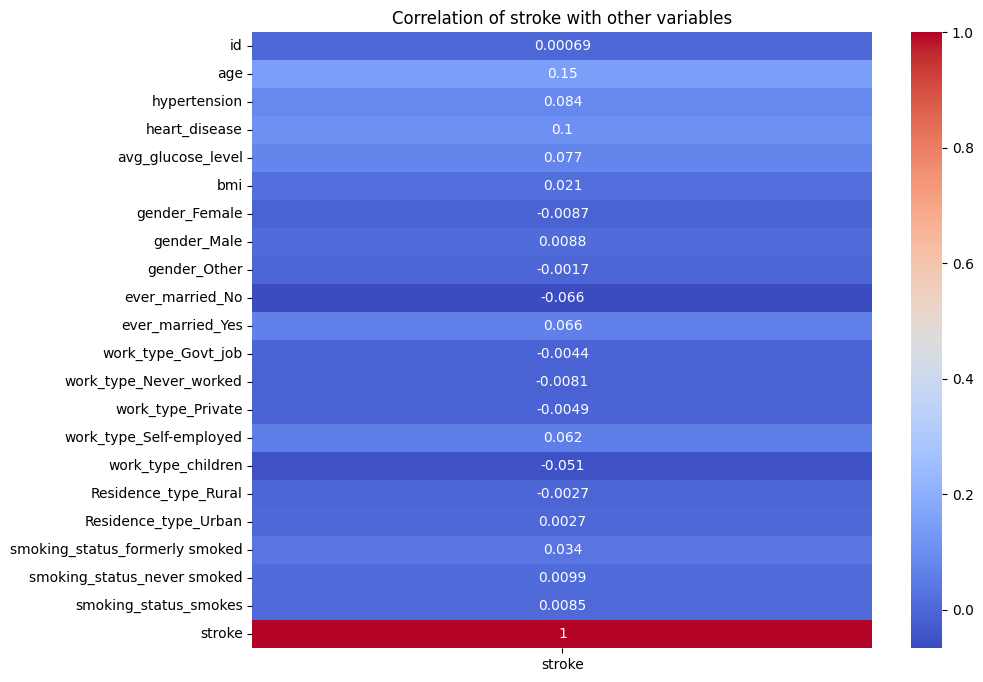

In [375]:
sf.corrplot(train_data, 'stroke', 'pearson')

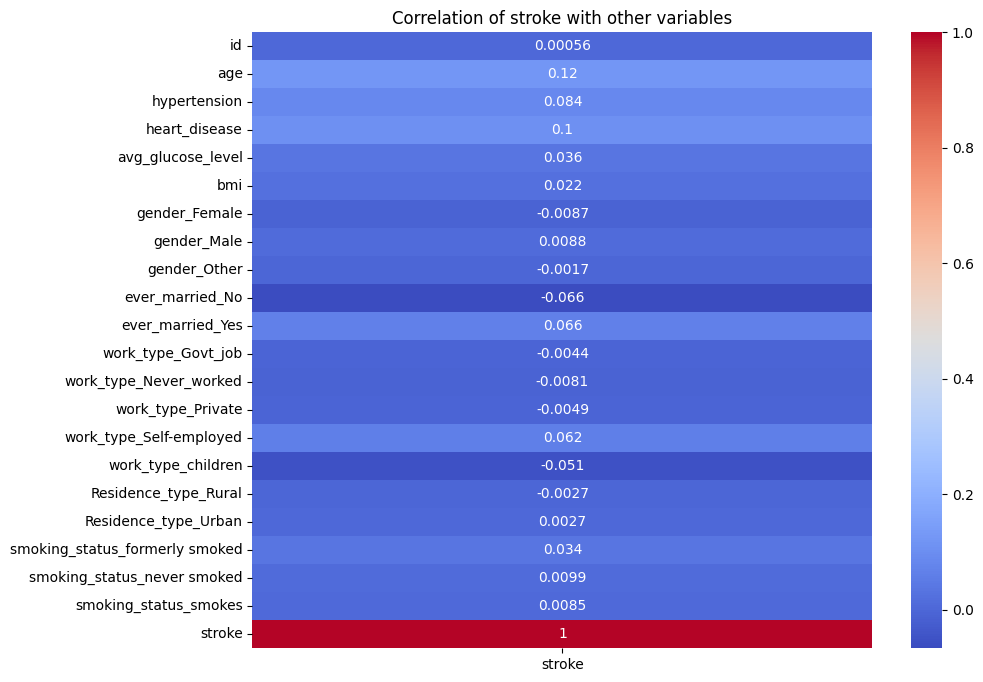

In [376]:
sf.corrplot(train_data, 'stroke', 'kendall')

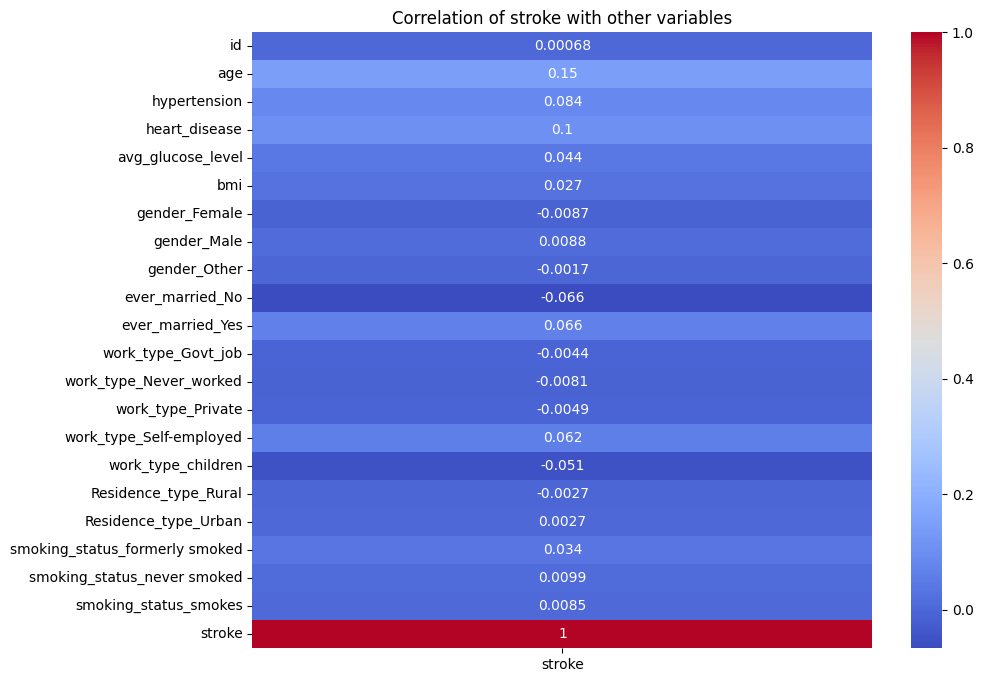

In [377]:
sf.corrplot(train_data, 'stroke', 'spearman')

## 2.5 Minimum requirements for Machine Learning with Scikit Learn

- No missing values: there are no missing values in the dataset which is required for machine learning with Scikit Learn
- Numeric or Boolean values: all columns are in either numeric or Boolean data types which is required for machine learning with Scikit Learn

## 2.6 Conclusion

# 3. Data preparation 

## 3.1 Column selection

Remove columns which a multicolinear columns

In [378]:
col_to_drop = ['id', 'gender_Male', 'gender_Other', 'ever_married_Yes', 'Residence_type_Urban']

train_data = train_data.drop(col_to_drop, axis=1)
test_data = test_data.drop(col_to_drop, axis=1)

## 3.2 Remove outliers

For average glucose levels and BMI we have an extreme right-skewed. Therefore we will be removing the outliers using the Z-score, all values with a Z-score above 3 will be removed.

In [379]:
bmi_zscore = sf.z_score(train_data['bmi'])
glucose_zscore = sf.z_score(train_data['avg_glucose_level'])

train_data['bmi'] = bmi_zscore
train_data['avg_glucose_level'] = glucose_zscore

train_data = train_data[(train_data['bmi'] < 3) & (train_data['avg_glucose_level'] < 3)]

## 3.3 Feature selection

After running all the models, we calculated the feature importances and put them in this table:
![](Figures/output_table_1.png)
We decided to drop all the features with a feature importance below 0.05

In [380]:
cols_to_drop = ['Residence_type_Rural', 'gender_Female', 'bmi', 'smoking_status_formerly smoked', 'work_type_Private', 'work_type_Never_worked', 'smoking_status_never smoked', 'work_type_Govt_job']

train_data = train_data.drop(cols_to_drop, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)

## 3.4 Creating X and y

In [381]:
X_train = train_data.drop('stroke', axis=1)
y_train = train_data['stroke']

## 3.5 Data sampling

Check how many True/False values there are in the train set

In [382]:
y_train.value_counts()

0    32151
1      478
Name: stroke, dtype: int64

In [383]:
#rus = RandomUnderSampler()
#
#X_train, y_train = rus.fit_resample(X_train, y_train)

In [384]:
#smote = SMOTE()
#
#X_train, y_train = smote.fit_resample(X_train, y_train)

Check how many True/False values there are in the train set

In [385]:
y_train.value_counts()

0    32151
1    32151
Name: stroke, dtype: int64

## 3.6 Standardizing data

The columns containing data of the float type will be standardized using Scikit Learn's standardscaler. It is important to standardize the data, this prevents columns with high values to have an unreasonably large impact. The way the standarscaler scales is using the standard deviation and the mean to calculate the Z-score

In [386]:
sc = StandardScaler()

sf.sta_sca(sc, X_train, ['age', 'avg_glucose_level'])
sf.sta_sca(sc, test_data, ['age', 'avg_glucose_level'])

# 5. Models

## 5.1 K-Nearest Neighbours

### 5.1.1 Hyperparameter tuning

In [387]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
knn_cv = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

### 5.1.2 Training KNN

In [388]:
knn_cv.fit(X_train, y_train)
print("Best parameters: ", knn_cv.best_params_)
print("Best cross-validation score: ", knn_cv.best_score_)

Best parameters:  {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation score:  0.8953336136535854


### 5.1.3 Predicting KNN

In [389]:
knn_pred = knn_cv.predict(test_data)

knn_pred_df = test_data_ids.to_frame()
knn_pred_df['stroke'] = knn_pred

### 5.1.4 Writing to CSV

In [390]:
knn_pred_df.to_csv('Datasets/Predictions/knn_pred.csv', index=False)

## 5.2 Logistic Regression

### 5.2.1 Hyperparameter tuning

In [391]:
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1.0], 'solver': ['liblinear', 'newton-cholesky']}
lr_cv = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

In [ ]:
# the variabel C is the inverse of the reuglaization strength, the smaller the value the stronger the regularization
# regularization is used to prevent overfitting, making the model more generalizable and not memorizing the training data.
#regularization is making the coefficients of the model smaller, so the model is less likely to overfit the training data
#the regularization penalty is the L1 or L2 norm of the coefficients, L1 is the sum of the absolute values of the coefficients, L2 is the sum of the squared values of the coefficients
#L1 regularization is used for feature selection, it makes some of the coefficients zero, effectively removing the feature from the model. 
#L2 regularization is used for preventing overfitting, it makes the coefficients smaller, but not zero
#elasticnet is a combination of L1 and L2 regularization, it has two hyperparameters, l1_ratio and alpha, l1_ratio is the ratio of L1 regularization, alpha is the regularization strength
#GridsearchCV is used to find the best hyperparameters for the model, it uses cross-validation to evaluate the model with different hyperparameters
#cross-validation is used to evaluate the model on different subsets of the training data, it is used to prevent overfitting and to get a more accurate estimate of the model's performance
#smaller C values leads to less confident predictions, because the raw output is closer to 0, thus the probability is closer to 0.5, after the model output is transformed by the sigmoid function.

### 5.1.2 Training LR

In [392]:
lr_cv.fit(X_train, y_train)
print("Best parameters: ", lr_cv.best_params_)
print("Best cross-validation score: ", lr_cv.best_score_)

Best parameters:  {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score:  0.7974738160756464


In [ ]:
#training the model means finding the best coefficients for the model, the coefficients are the weights of the features in the model
#the features are the input variables of the model, the coefficients are the weights of the features, they are multiplied by the feature values to get the output of the model


### 5.1.3 Predicting LR

In [393]:
lr_pred = lr_cv.predict(test_data)

lr_pred_df = test_data_ids.to_frame()
lr_pred_df['stroke'] = lr_pred

### 5.1.4 Writing to CSV

In [394]:
lr_pred_df.to_csv('Datasets/Predictions/lr_pred.csv', index=False)

## 5.3 SVM

### 5.3.1 Hyperparameter tuning

In [395]:
svc = SVC()

param_grid = {'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 4, 5], 'gamma': ['auto'], 'C': [0.001, 0.01, 0.1, 1.0]}
svc_cv = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

In [ ]:
#svm uses the hinge loss function, it tries to maximize the margin between the classes, the margin is the distance between the decision boundary and the closest points of the classes and it uses l2 regularization to prevent overfitting.
#support vectors are the points that are closest to the decision boundary, they are the points that define the margin of the classes
#all incorrectly predicted classes are the support vectors
#kernel svm uses the kernel trick to transform the data into a higher dimensional space, where the classes are linearly separable, the kernel function is used to calculate the similarity between the points in the higher dimensional space and then the decision boundary is calculated in the higher dimensional space and then transformed back to the original space where the classes are not linearly separable. here gamma is used to control the smoothness of the decision boundary, the higher the gamma the more complex the decision boundary, the lower the gamma the simpler the decision boundary.
#it is a trade between train accuracy and generalization, the higher the gamma the higher the train accuracy, but the lower the generalization, the lower the gamma the lower the train accuracy, but the higher the generalization --> overfitting
#cross validation is used to evaluate the model on different subsets of the training data, it is used to prevent overfitting and to get a more accurate estimate of the model's performance. F1 is used as the scoring metric, it is the harmonic mean of precision and recall, it is used to evaluate the model's performance on imbalanced datasets, it is the best metric for imbalanced datasets beacause it takes into account both false positives and false negatives.


### 5.3.2 Training SVC

In [396]:
svc_cv.fit(X_train, y_train)
print("Best parameters: ", svc_cv.best_params_)
print("Best cross-validation score: ", svc_cv.best_score_)

Best parameters:  {'C': 1.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score:  0.7980947089741174


In [ ]:
#the best parameters in our case are kernel = rbf, degree = 2, gamma = auto, C = 1.0. That means that the best model is a support vector machine with a radial basis function kernel, a degree of 2, an automatic gamma value and a regularization strength of 1.0.
#Furthermore, the best cross-validation score is 0.798. This means that the model has an average f1 score of 0.798 on the validation sets during cross-validation.
#a 

### 5.3.3 Predicting SVC

In [397]:
svc_pred = svc_cv.predict(test_data)

svc_pred_df = test_data_ids.to_frame()
svc_pred_df['stroke'] = svc_pred

### 5.3.4 Writing to CSV

In [398]:
svc_pred_df.to_csv('Datasets/Predictions/svc_pred.csv', index=False)

## 5.4 Decision Tree

### 5.4.1 Hyperparameter tuning

In [399]:
dt = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2']}
dt_cv = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

### 5.4.2 Training DT

In [400]:
dt_cv.fit(X_train, y_train)
print("Best parameters: ", dt_cv.best_params_)
print("Best cross-validation score: ", dt_cv.best_score_)

Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
Best cross-validation score:  0.8415657351195541


### 5.4.3 Predicting DT

In [401]:
dt_pred = dt_cv.predict(test_data)

dt_pred_df = test_data_ids.to_frame()
dt_pred_df['stroke'] = dt_pred

### 5.4.4 Writing to CSV

In [402]:
dt_pred_df.to_csv('Datasets/Predictions/dt_pred.csv', index=False)

## 5.5 Ensembles

### 5.5.1 Random Forest

#### 5.5.1.1 Hyperparameter tuning

In [403]:
rf = RandomForestClassifier()

param_grid = {'n_estimators': [50], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True]}
rf_cv = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

#### 5.5.1.2 Training RF

In [404]:
rf_cv.fit(X_train, y_train)
print("Best parameters: ", rf_cv.best_params_)
print("Best cross-validation score: ", rf_cv.best_score_)

Best parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
Best cross-validation score:  0.8717849188670568


#### 5.5.1.3 Predicting RF

In [405]:
rf_pred = rf_cv.predict(test_data)

rf_pred_df = test_data_ids.to_frame()
rf_pred_df['stroke'] = rf_pred

#### 5.5.1.4 Writing to CSV

In [406]:
rf_pred_df.to_csv('Datasets/Predictions/rf_pred.csv', index=False)

### 5.5.2 Gradient Boosting Classifier

#### 5.5.2.1 Hyperparameter tuning

In [407]:
gb = GradientBoostingClassifier()

param_grid = {'loss': ['log_loss', 'exponential'], 'n_estimators': [50], 'criterion': ['friedman_mse', 'squared_error'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['sqrt', 'log2']}
gb_cv = GridSearchCV(estimator=gb, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

#### 5.5.2.2 Training GB

In [408]:
gb_cv.fit(X_train, y_train)
print("Best parameters: ", gb_cv.best_params_)
print("Best cross-validation score: ", gb_cv.best_score_)

Best parameters:  {'criterion': 'squared_error', 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}
Best cross-validation score:  0.9164921490500427


#### 5.5.2.3 Predicting GB

In [409]:
gb_pred = gb_cv.predict(test_data)

gb_pred_df = test_data_ids.to_frame()
gb_pred_df['stroke'] = gb_pred

#### 5.5.2.4 Writing to CSV

In [410]:
gb_pred_df.to_csv('Datasets/Predictions/gb_pred.csv', index=False)

### 5.5.3 XGBoost

## 6. Deciding feature importances

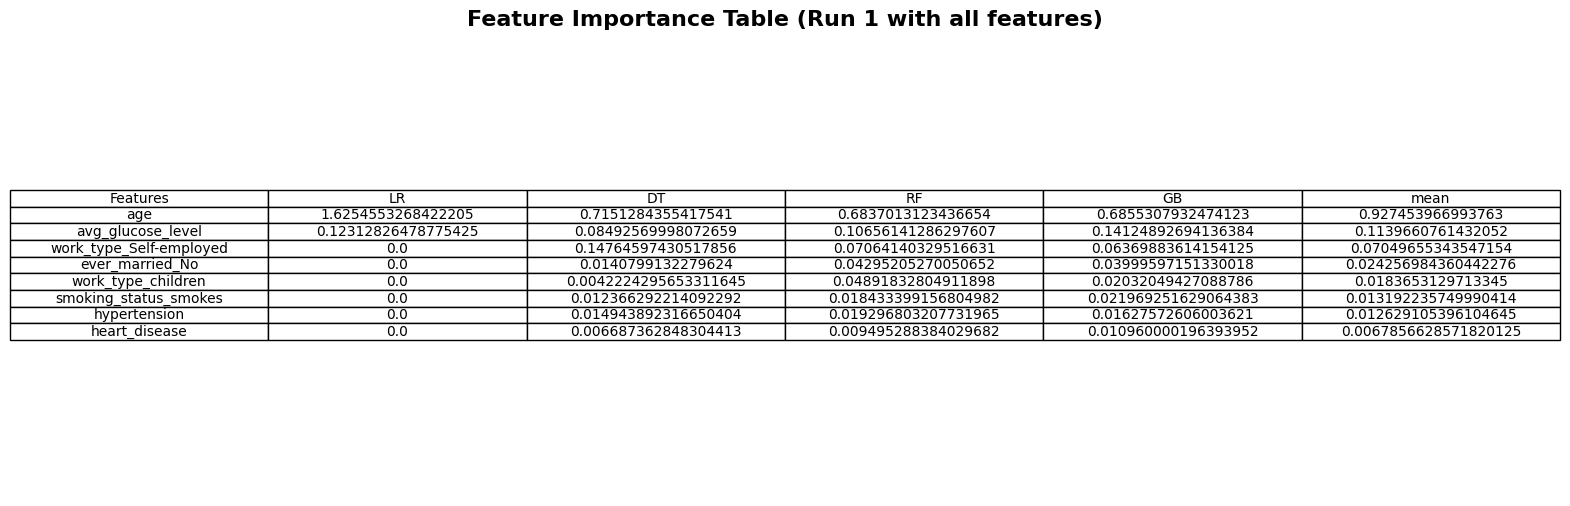

In [411]:
#lr_fi = lr_cv.best_estimator_.coef_
#dt_fi = dt_cv.best_estimator_.feature_importances_
#rf_fi = rf_cv.best_estimator_.feature_importances_
#gb_fi = gb_cv.best_estimator_.feature_importances_
#
#fi_df = pd.DataFrame({'Features': X_train.columns, 'LR': lr_fi[0], 'DT': dt_fi, 'RF': rf_fi, 'GB': gb_fi})
#fi_df['LR'] = np.abs(fi_df['LR'])
#fi_df['mean'] = fi_df.mean(axis=1)
#
#fi_df = fi_df.sort_values(by='mean', ascending=False)
#
#fig, ax = plt.subplots(figsize=(20, 6))
#ax.axis('tight')
#ax.axis('off')
#ax.table(cellText=fi_df.values, colLabels=fi_df.columns, cellLoc='center', loc='center')
#
#ax.set_title("Feature Importance Table (Run 1 with all features)", fontsize=16, fontweight='bold')
#
#plt.savefig('Figures/output_table_2.png', format='png')
#
#plt.show()